# Import all dependencies
<h3 style="color:red; font-weight:bold; text-decoration: underline">If the Google Translate python package is not already installed run the following command to install it:
 \n`pip install googletrans` </div>

In [43]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates
from wordcloud import WordCloud
from datetime import datetime
from googletrans import Translator
%matplotlib inline

In [2]:
#import data
twitter_user = pd.read_csv('./datasets/users.csv')
tweets = pd.read_csv('./datasets/tweets.csv')

# Clean Twitter_user dataframe

In [3]:
#view missing data
missing_user_df = twitter_user.isnull().sum(axis=0)
missing_user_df

id                   61
location            169
name                 70
followers_count      70
statuses_count       70
time_zone            85
verified             70
lang                 70
screen_name           0
description         115
created_at           70
favourites_count     70
friends_count        70
listed_count         70
dtype: int64

In [4]:
#remove missing data if the location is missing
twitter_user.dropna(subset=['location'], inplace=True)

In [5]:
#Replace null values in description with phrase "no description"
twitter_user['description'].fillna('no description', inplace=True)

In [6]:
twitter_user.dropna(subset=['time_zone'], inplace=True)
twitter_user.isnull().sum(axis=0)

id                  0
location            0
name                0
followers_count     0
statuses_count      0
time_zone           0
verified            0
lang                0
screen_name         0
description         0
created_at          0
favourites_count    0
friends_count       0
listed_count        0
dtype: int64

# Twitter_user data wrangling

### Reformating created_str to month and year columns

In [7]:
current_date = '%a %b %d %H:%M:%S %z %Y'
month = '%m'
year = '%Y'
twitter_user['month'] = (twitter_user.created_at.map(
    lambda x: datetime.strptime(str(x), current_date).strftime(month)))
twitter_user['year'] = (twitter_user.created_at.map(
    lambda x: datetime.strptime(str(x), current_date).strftime(year)))

### Translate description, location, and usernames to english

In [8]:
# for the location column, look at all the text first identify all the non-english language, add all the
#language types to the language array and then convert everything to english
language_count = []
translator = Translator()
i = 0;
for location in twitter_user['location'].values:
#first detect the language
    lang_detect = translator.detect(location)
#if the language isn't english, translate it to english
    if(lang_detect.lang != 'en'):
        translation = translator.translate(location, dest='en')
        twitter_user['location'].values[i] = translation.text
    i = i+1

### Consolidate locations to the same name 
Example 'Moscow, Russia' and 'Moscow' should both be 'Moscow'

The country can be removed by removing the sub string after the comma

In [9]:
# in the location column consolidate locations to the same name 
# example 'Moscow, Russia' and 'Moscow' should both be 'Moscow'
# The country can be removed by removing the sub string after the comma
i = 0 
for location in twitter_user['location'].values:
    head, sep, tail = location.partition(',')
    twitter_user['location'].values[i] = head
    i = i+1

### Replace all 'us' labels with 'United States of America'

In [10]:
twitter_user['location'].replace({'USA':'United States of America',
                                  'usa':'United States of America',
                                  'US':'United States of America',
                                  'us':'United States of America',
                                  'United States':'United States of America',
                                  'united state':'United States of America', 
                                  'America':'United States of America',
                                  'america':'United States of America', 
                                  'murica':'United States of America', 
                                  'Murica':'United States of America',
                                  'united states of america':'United States of America'}, inplace = True)

### Change descriptions to english

In [11]:
translator = Translator()
i = 0;
for description in twitter_user['description'].values:
#first detect the language
    lang_detect = translator.detect(description)
#if the language isn't english, translate it to english
    if(lang_detect.lang != 'en'):
        translation = translator.translate(description, dest='en')
        twitter_user['description'].values[i] = translation.text
    i = i+1

## Clean Tweets dataframe

In [12]:
#remove unneeded columns such as: user_id, created_at (created_str is the same thing but in timedate format), and tweet_id
tweets.drop(columns=['user_id', 'created_at', 'tweet_id'], inplace= True)

In [13]:
#remove rows with more than 6 missing values
missing_tweet_data = tweets[tweets.isnull().sum(axis = 1) > 6]
#create list of missing indexs
missing_tweet_id = missing_tweet_data.index
#drop rows by index
tweets.drop(index = missing_tweet_id ,inplace = True)
tweets.isnull().sum(axis=0)
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203461 entries, 0 to 203481
Data columns (total 13 columns):
user_key                 203461 non-null object
created_str              203461 non-null object
retweet_count            58083 non-null float64
retweeted                58083 non-null object
favorite_count           58083 non-null float64
text                     203461 non-null object
source                   58083 non-null object
hashtags                 203461 non-null object
expanded_urls            203461 non-null object
posted                   203461 non-null object
mentions                 203461 non-null object
retweeted_status_id      39651 non-null float64
in_reply_to_status_id    559 non-null float64
dtypes: float64(4), object(9)
memory usage: 21.7+ MB


In [14]:
#replace null values in retweets_count, retweets, favorite_count, retweeted_status_id, 
#in_reply_to_status_id with 0
#replace null values in source with 'no source'
values={'retweet_count':0, 'retweeted':0, 'favorite_count':0, 'retweeted_status_id':0,'in_reply_to_status_id':0, 'source':'no source'}
tweets.fillna(value=values, inplace = True)
tweets.isnull().sum(axis=0)

user_key                 0
created_str              0
retweet_count            0
retweeted                0
favorite_count           0
text                     0
source                   0
hashtags                 0
expanded_urls            0
posted                   0
mentions                 0
retweeted_status_id      0
in_reply_to_status_id    0
dtype: int64

# Tweets Data Wrangling

### Create Month-Year column for sorting and plotting

In [15]:
current_date = '%Y-%m-%d %H:%M:%S'
month_year = '%Y-%m'
tweets['month_year'] = (tweets.created_str.map(
    lambda x: datetime.strptime(str(x), current_date).strftime(month_year)))

In [16]:
len(tweets['month_year'].unique())

38

### Cleaning Hashtag column, to get top used hashtags

In [ ]:
#remove opening square bracket "[", remove "u", remove close quote "'" 
#remove close bracket "]"
rm_opsq = lambda s: re.sub(r'\[', '',s)
rm_u = lambda s: re.sub(r'u\'','', s)
rm_quote = lambda s: re.sub(r'\'','', s)
rm_clsq = lambda s: re.sub(r'\]','', s)
#split actor_list by comma to create an array or each actor
split_hashtag = lambda s: s.split(',')

In [ ]:
#run all regex commands
hashtags = tweets['hashtags'].map(rm_opsq).map(rm_u).map(rm_quote).map(rm_clsq)

In [ ]:
#create hashtags_df by spliting on the comma in the list
hashtags_df = pd.DataFrame(hashtags.map(split_hashtag).tolist())

In [123]:
#save non empty hastags to hastags array
#htags will hold all the non-empty hashtags
htags= []
#get each hashtag row in hashtags_df 
for hashtag in hashtags_df.values:
    #get each hashtag in the selected hashtag row
    for tag in hashtag:
        #if the hashtag is not null append it to htag
        if tag:
            htags.append(tag)
#created hashtag dataframe from htags list for data wrangling
hashtags = pd.DataFrame(data=htags)

In [133]:
#get top 30 hashtags
top_hashtags = hashtags[0].value_counts().nlargest(30)
#sort by most used
top_hashtags.sort_values(ascending=False, inplace=True)
top_hashtags.reindex()

"Politics"                        3606
"maga"                            3079
"Trump"                           2425
"tcot"                            2366
"news"                            1973
"NeverHillary"                    1375
"pjnet"                           1276
"TrumpPence16"                     980
"Trump2016"                        947
"MerkelMussBleiben"                796
"Hillary"                          758
"TrumpTrain"                       719
"HillaryClinton"                   704
"CrookedHillary"                   678
"WakeUpAmerica"                    661
"RejectedDebateTopics"             657
"CCOT"                             600
"Obama"                            599
"Blacklivesmatter"                 581
"2A"                               565
"BetterAlternativeToDebates"       554
"p2"                               548
"imwithher"                        542
"ThingsYouCantIgnore"              526
"SurvivalGuideToThanksgiving"      519
"IHaveARightToKnow"      

# Twitter_user data visualization

### Number of accounts created by year and month
Looking the graph below it looks like most accounts were created in 2013 and 2015, just before the election began to ramp up. None of the accounts created are verifed, mean no account holds an offical status in terms of being a top/popular, user verify twitter account. 

In [17]:
print('If the account verification returns false, then it is not a verified account')
print('Number of verified accounts:', twitter_user['verified'].value_counts())

If the account verification returns false, then it is not a verified account
Number of verified accounts: False    279
Name: verified, dtype: int64


In [18]:
months = twitter_user.groupby(by=[twitter_user.month]).count()
Years = twitter_user.groupby([twitter_user.year]).count()

Text(0.25,75,'Trump Elected in January')

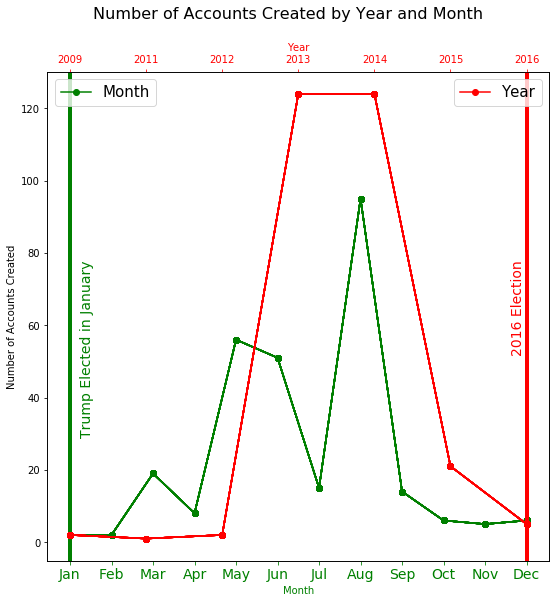

In [19]:
#plot graph about accounts created by time
fig = plt.figure(figsize=(9,9))
fig.suptitle('Number of Accounts Created by Year and Month ', fontsize=16)
axis1 = fig.add_subplot(111)
axis1.plot(months, marker = 'o', color='g')
axis1.set_ylabel('Number of Accounts Created' )
axis1.set_xlabel('Month', color='g')
axis1.tick_params('x', colors='g')
axis1.set_xticklabels(labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], fontsize=14)
#Number of Accounts created by year
axis2 = axis1.twiny()
axis2.plot(Years, marker = 'o', color='r')
axis2.set_ylabel('Number of Accounts Created')
axis2.set_xlabel('Year', color='r')
axis2.tick_params('x', colors='r')

axis1.legend(['Month'], loc='upper left', fontsize='15')
axis2.legend(['Year'], loc='upper right', fontsize='15')

axis2.axvline(x='2016', linewidth=4, color='r')
axis2.text(5.8,75,'2016 Election',rotation=90, fontsize='14', color='r')
axis1.axvline(x='01', linewidth=4, color='g')
axis1.text(0.25,75,'Trump Elected in January',rotation=90, fontsize='14', color='g')

### Account Origin

(array([  0.,  20.,  40.,  60.,  80., 100., 120., 140.]),
 <a list of 8 Text xticklabel objects>)

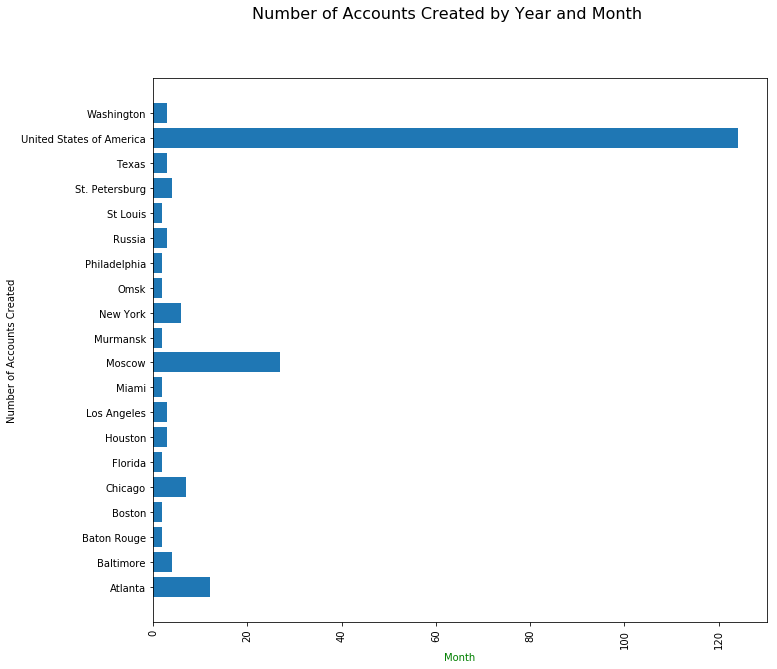

In [20]:
#plot graph about accounts created by time
fig = plt.figure(figsize=(11,10))
fig.suptitle('Number of Accounts Created by Year and Month ', fontsize=16)
axis3 = fig.add_subplot(111)
axis3.barh(twitter_user['location'].value_counts().index[:20], twitter_user['location'].value_counts()[:20])
axis3.set_ylabel('Number of Accounts Created')
axis3.set_xlabel('Month', color='g')
plt.xticks(rotation=90)

(array([-50.,   0.,  50., 100., 150., 200., 250., 300., 350., 400., 450.]),
 <a list of 11 Text xticklabel objects>)

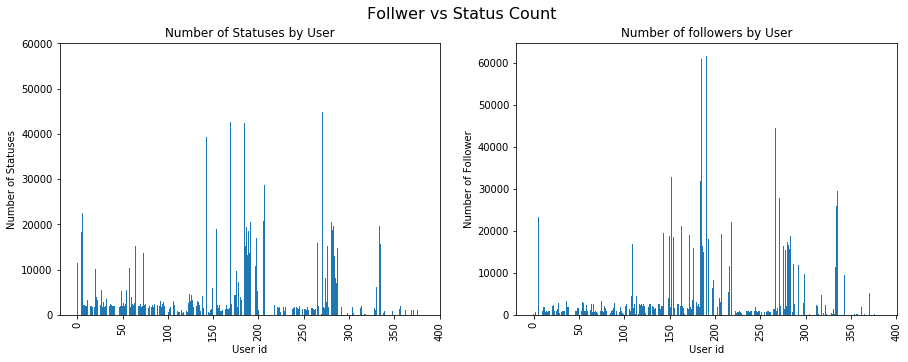

In [21]:
#plot graph about accounts created by time
fig = plt.figure(figsize=(15,5))
fig.suptitle('Follwer vs Status Count ', fontsize=16)
axis4 = fig.add_subplot(121)
axis4.bar(twitter_user['statuses_count'].index, twitter_user['statuses_count'])
axis4.set_title('Number of Statuses by User')
axis4.set_ylabel('Number of Statuses')
axis4.set_xlabel('User id')
plt.xticks(rotation=90)
axis5 = fig.add_subplot(122)
axis5.bar(twitter_user['followers_count'].index, twitter_user['followers_count'])
axis5.set_title('Number of followers by User')
axis5.set_ylabel('Number of Follower')
axis5.set_xlabel('User id')
plt.xticks(rotation=90)

In [22]:
#Follower_Count
follower_count_mean = twitter_user['followers_count'].mean()
follower_count_median = twitter_user['followers_count'].median()
print('The average "Russian Troll Account" has:', follower_count_mean, 'Followers')
print('The median "Russian Troll Account" has:', follower_count_median, 'Followers')
#Status Count
statuses_count_mean = twitter_user['statuses_count'].mean()
statuses_count_median = twitter_user['statuses_count'].median()
print('The average "Russian Troll Account" has:', statuses_count_mean, 'statuses')
print('The median "Russian Troll Account" has:', statuses_count_median, 'statuses')

The average "Russian Troll Account" has: 4492.763440860215 Followers
The median "Russian Troll Account" has: 1609.0 Followers
The average "Russian Troll Account" has: 4911.1612903225805 statuses
The median "Russian Troll Account" has: 1889.0 statuses


(-0.5, 399.5, 199.5, -0.5)

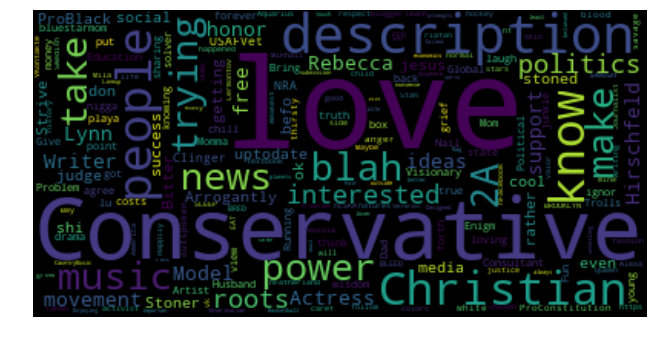

In [23]:
tweet_text = WordCloud().generate(str(twitter_user['description']))
# Display the generated image:
# the matplotlib way:
fig = plt.figure(figsize=(11,10))
axis1 = fig.add_subplot(111)
axis1.imshow(tweet_text, interpolation='bilinear')
axis1.axis("off")

# Tweets data Visualization

In [24]:
date = tweets.groupby(by=[tweets['month_year'].sort_values()]).count()
date.head()

,user_key,created_str,retweet_count,retweeted,favorite_count,text,source,hashtags,expanded_urls,posted,mentions,retweeted_status_id,in_reply_to_status_id,month_year
month_year,,,,,,,,,,,,,,
2014-07,12,12,12,12,12,12,12,12,12,12,12,12,12,12
2014-08,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2014-09,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2014-11,388,388,388,388,388,388,388,388,388,388,388,388,388,388
2014-12,442,442,442,442,442,442,442,442,442,442,442,442,442,442


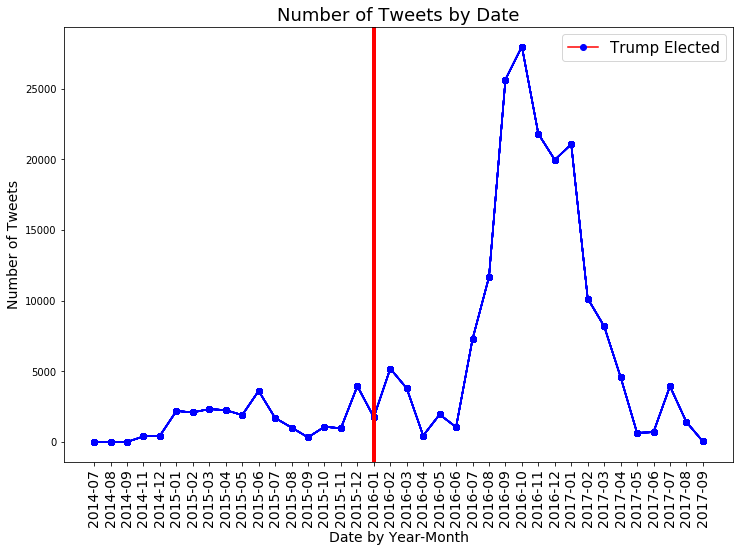

In [25]:
fig = plt.figure(figsize=(12,8))
axis6 = fig.add_subplot(111)
plt.xticks(rotation=90, fontsize='14')
axis6.plot(date, marker = 'o', color='b')
axis6.set_title('Number of Tweets by Date', fontsize='18')
axis6.set_ylabel('Number of Tweets', fontsize='14')
axis6.set_xlabel('Date by Year-Month', fontsize='14')

axis6.axvline(x='2016-01', linewidth=4, color='r', label='2016 Election')

axis6.legend(['Trump Elected'], loc='upper right', fontsize='15')
leg = axis6.get_legend()
leg.legendHandles[0].set_color('red')

### Retweets count

In [26]:
retweet = tweets['retweet_count'].value_counts().describe()
print("A total of",retweet[0],"have been retweeted")
print("Of the Tweets retweeted, they were retweeted", int(retweet[1]), "times on average")

A total of 1229.0 have been retweeted
Of the Tweets retweeted, they were retweeted 165 times on average


In [27]:
retweet_count = tweets.sort_values(by='retweet_count', ascending=False)['retweet_count'].value_counts()
retweet_count = retweet_count.drop([0]).nlargest(15)

Text(0.5,0,'Number of Retweets')

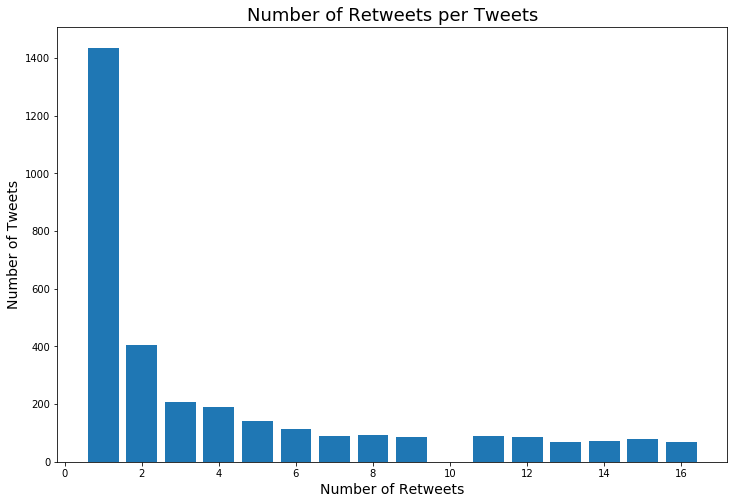

In [28]:
fig = plt.figure(figsize=(12,8))
axis7 = fig.add_subplot(111)
axis7.bar(retweet_count.index, retweet_count.values)
axis7.set_title('Number of Retweets per Tweets', fontsize='18')
axis7.set_ylabel('Number of Tweets', fontsize='14')
axis7.set_xlabel('Number of Retweets', fontsize='14')

Text(0.5,0,'Number of time the Hashtag was Retweeted')

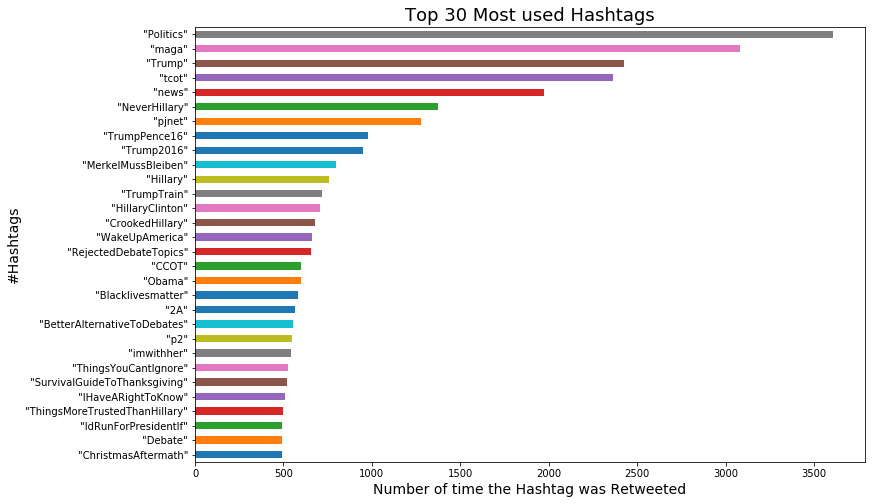

In [138]:
fig = plt.figure(figsize=(12,8))
axis7 = fig.add_subplot(111)
#axis7.barh(top_hashtags.index, top_hashtags.values)
top_hashtags.sort_values(ascending=True).plot.barh()
axis7.set_title('Top 30 Most used Hashtags', fontsize='18')
axis7.set_ylabel('#Hashtags', fontsize='14')
axis7.set_xlabel('Number of time the Hashtag was Retweeted', fontsize='14')

(-0.5, 399.5, 199.5, -0.5)

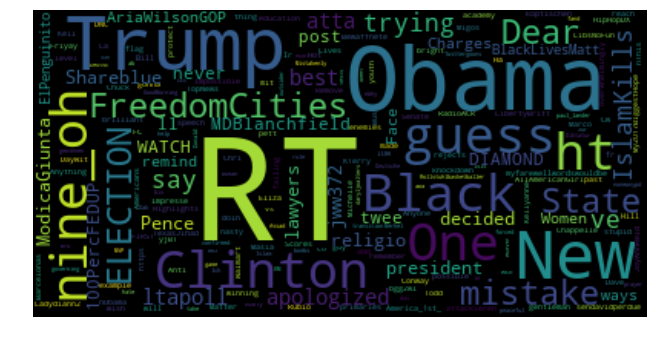

In [33]:
tweet_text = WordCloud().generate(str(tweets['text']))
# Display the generated image:
# the matplotlib way:
fig = plt.figure(figsize=(11,10))
axis1 = fig.add_subplot(111)
axis1.imshow(tweet_text, interpolation='bilinear')
axis1.axis("off")

(-0.5, 399.5, 199.5, -0.5)

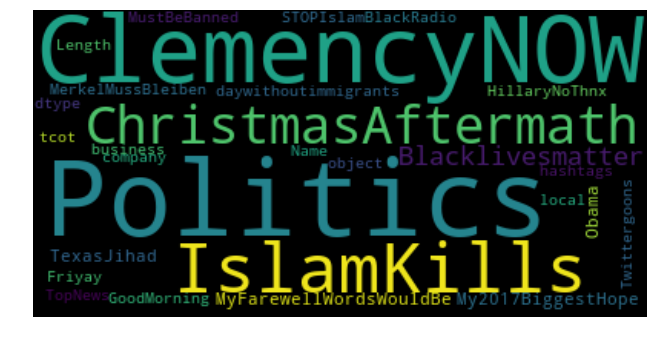

In [34]:
hashtags = WordCloud().generate(str(tweets['hashtags']))
# Display the generated image:
# the matplotlib way:
fig = plt.figure(figsize=(11,10))
axis2 = fig.add_subplot(111)
axis2.imshow(hashtags, interpolation='bilinear')
axis2.axis("off")